# 故障树不确定性


## 概述

本讲将运用基本工具来近似计算由多个关键部件组成的系统的年度故障率的概率分布。

我们将使用对数正态分布来近似关键组件部件的概率分布。

为了近似描述整个系统故障率的n个对数正态概率分布之**和**的概率分布，我们将计算这n个对数正态概率分布的卷积。

我们将使用以下概念和工具：

* 对数正态分布
* 描述独立随机变量之和的概率分布的卷积定理

* 用于近似多组件系统故障率的故障树分析
* 用于描述不确定概率的层次概率模型
* 傅里叶变换和逆傅里叶变换作为计算序列卷积的高效方法

关于傅里叶变换的更多信息，请参见这个 quantecon 讲座 [循环矩阵](https://python.quantecon.org/eig_circulant.html)
以及这些讲座 [协方差平稳过程](https://python-advanced.quantecon.org/arma.html) 和 [谱估计](https://python-advanced.quantecon.org/estspec.html)。

El-Shanawany, Ardron 和 Walker {cite}`Ardron_2018` 以及 Greenfield 和 Sargent {cite}`Greenfield_Sargent_1993` 使用了这里描述的一些方法来近似核设施安全系统的故障概率。

这些方法响应了 Apostolakis {cite}`apostolakis1990` 提出的关于构建量化程序的一些建议。

对安全系统可靠性的不确定性。

我们先引入一些Python工具。

In [1]:
!pip install tabulate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

from scipy.signal import fftconvolve
from tabulate import tabulate
import time

In [3]:
np.set_printoptions(precision=3, suppress=True)

<!-- #region -->

## 对数正态分布

如果一个随机变量 $x$ 服从均值为 $\mu$ 和方差为 $\sigma^2$ 的正态分布，那么 $x$ 的自然对数，即 $y = \log(x)$，就服从参数为 $\mu, \sigma^2$ 的**对数正态分布**。

注意我们说的是**参数**而不是**均值和方差** $\mu,\sigma^2$。

 * $\mu$ 和 $\sigma^2$ 是 $x = \exp (y)$ 的均值和方差
 * 它们**不是** $y$ 的均值和方差
 * 相反，$y$ 的均值是 $e ^{\mu + \frac{1}{2} \sigma^2}$，$y$ 的方差是 $(e^{\sigma^2} - 1) e^{2 \mu + \sigma^2} $

对数正态随机变量 $y$ 是非负的。

对数正态随机变量 $y$ 的密度函数是

$$ f(y) = \frac{1}{y \sigma \sqrt{2 \pi}} \exp \left(  \frac{- (\log y - \mu)^2 }{2 \sigma^2} \right) $$

其中 $y \geq 0$。

对数正态随机变量的重要特征是

$$
\begin{aligned}
 \textrm{均值:} & \quad e ^{\mu + \frac{1}{2} \sigma^2} \cr

\textrm{方差:}  & \quad (e^{\sigma^2} - 1) e^{2 \mu + \sigma^2} \cr
  \textrm{中位数:} & \quad e^\mu \cr
 \textrm{众数:} & \quad e^{\mu - \sigma^2} \cr
 \textrm{.95 分位数:} & \quad e^{\mu + 1.645 \sigma} \cr
 \textrm{.95-.05 分位数比:}  & \quad e^{1.645 \sigma} \cr
 \end{aligned}
$$


回顾两个独立正态分布随机变量的以下_稳定性_性质：

如果$x_1$是均值为$\mu_1$、方差为$\sigma_1^2$的正态分布，且$x_2$独立于$x_1$并且是均值为$\mu_2$、方差为$\sigma_2^2$的正态分布，那么$x_1 + x_2$是均值为$\mu_1 + \mu_2$、方差为$\sigma_1^2 + \sigma_2^2$的正态分布。


独立的对数正态分布具有不同的_稳定性_性质。

独立对数正态随机变量的**乘积**也是对数正态分布。


特别地，如果$y_1$是参数为$(\mu_1, \sigma_1^2)$的对数正态分布，且

$y_2$ 是对数正态分布，参数为 $(\mu_2, \sigma_2^2)$，那么乘积 $y_1 y_2$ 也是对数正态分布，其参数为 $(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)$。

```{note}
虽然两个对数正态分布的乘积是对数正态分布，但两个对数正态分布的**和**却**不是**对数正态分布。
```

这个观察为我们在本讲中面临的挑战奠定了基础，即如何近似独立对数正态随机变量**和**的概率分布。

要计算两个对数正态分布之和的概率分布，我们可以使用独立随机变量之和的概率分布的卷积性质。

## 卷积性质

设 $x$ 是概率密度为 $f(x)$ 的随机变量，其中 $x \in {\bf R}$。

设 $y$ 是概率密度为 $g(y)$ 的随机变量，其中 $y \in {\bf R}$。

设 $x$ 和 $y$ 是独立随机变量，且 $z = x + y \in {\bf R}$。

那么 $z$ 的概率分布为

$$ h(z) = (f * g)(z) \equiv \int_{-\infty}^\infty f (z) g(z - \tau) d \tau $$

其中 $(f*g)$ 表示两个函数 $f$ 和 $g$ 的**卷积**。

如果随机变量都是非负的，则上述公式可简化为

$$ h(z) = (f * g)(z) \equiv \int_{0}^\infty f (z) g(z - \tau) d \tau $$

下面，我们将使用上述公式的离散化版本。

具体来说，我们将把 $f$ 和 $g$ 都替换为离散化的对应形式，并归一化使其和为1，这样它们就是概率分布。

  * **离散化**指的是等间隔采样的版本

然后我们将使用以下版本的公式

$$ h_n = (f*g)_n = \sum_{m=0}^\infty f_m g_{n-m} , n \geq 0 $$

来计算两个随机变量之和的概率分布的离散化版本，其中一个随机变量的概率质量函数为 $f$，另一个的概率质量函数为 $g$。

在应用卷积性质到对数正态分布的和之前，让我们先用一些简单的离散分布来练习。

以一个例子来说，让我们考虑以下两个概率分布

$$ f_j = \textrm{Prob} (X = j), j = 0, 1 $$

和

$$ g_j = \textrm{Prob} (Y = j ) , j = 0, 1, 2, 3 $$

和

$$ h_j = \textrm{Prob} (Z \equiv X + Y = j) , j=0, 1, 2, 3, 4 $$

卷积性质告诉我们

$$ h = f* g = g* f $$

让我们使用`numpy.convolve`和`scipy.signal.fftconvolve`来计算一个例子。

In [4]:
f = [.75, .25]
g = [0., .6,  0., .4]
h = np.convolve(f,g)
hf = fftconvolve(f,g)

print("f = ", f,  ", np.sum(f) = ", np.sum(f))
print("g = ", g, ", np.sum(g) = ", np.sum(g))
print("h = ", h, ", np.sum(h) = ", np.sum(h))
print("hf = ", hf, ",np.sum(hf) = ", np.sum(hf))

f =  [0.75, 0.25] , np.sum(f) =  1.0
g =  [0.0, 0.6, 0.0, 0.4] , np.sum(g) =  1.0
h =  [0.   0.45 0.15 0.3  0.1 ] , np.sum(h) =  1.0
hf =  [0.   0.45 0.15 0.3  0.1 ] ,np.sum(hf) =  1.0000000000000002


稍后我们将解释使用`scipy.signal.ftconvolve`而不是`numpy.convolve`的一些优势。

它们提供相同的结果，但`scipy.signal.ftconvolve`要快得多。

这就是为什么我们在本讲座后面会依赖它。


## 近似分布

我们将构建一个示例来验证离散化分布能够很好地近似从底层连续分布中抽取的样本。

我们将首先生成25000个样本，包含三个独立的对数正态随机变量以及它们的两两和三重和。

然后我们将绘制直方图，并将其与适当离散化的对数正态分布的卷积进行比较。

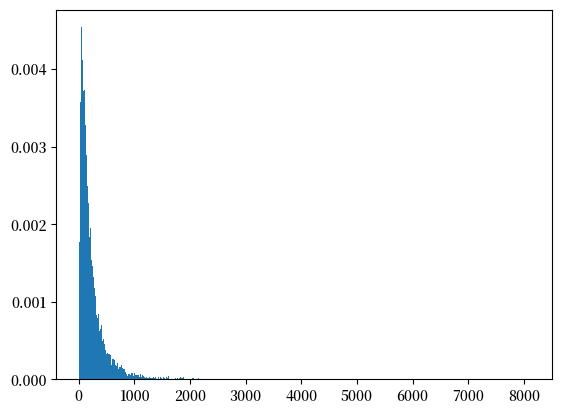

In [5]:
## 创建两个和三个对数正态随机变量的和 ssum2 = s1 + s2 和 ssum3 = s1 + s2 + s3


mu1, sigma1 = 5., 1. # 均值和标准差
s1 = np.random.lognormal(mu1, sigma1, 25000)

mu2, sigma2 = 5., 1. # 均值和标准差
s2 = np.random.lognormal(mu2, sigma2, 25000)

mu3, sigma3 = 5., 1. # 均值和标准差
s3 = np.random.lognormal(mu3, sigma3, 25000)

ssum2 = s1 + s2

ssum3 = s1 + s2 + s3

count, bins, ignored = plt.hist(s1, 1000, density=True, align='mid')

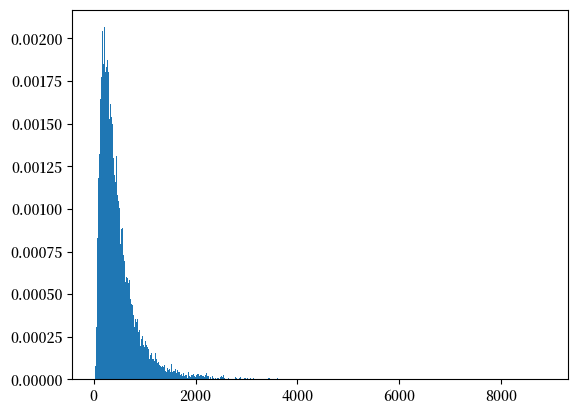

In [6]:
count, bins, ignored = plt.hist(ssum2, 1000, density=True, align='mid')

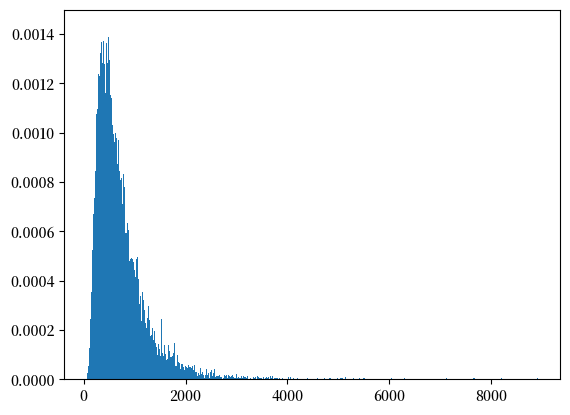

In [7]:
count, bins, ignored = plt.hist(ssum3, 1000, density=True, align='mid')

In [8]:
samp_mean2 = np.mean(s2)
pop_mean2 = np.exp(mu2+ (sigma2**2)/2)

pop_mean2, samp_mean2, mu2, sigma2

(244.69193226422038, 244.62844346232993, 5.0, 1.0)

以下是创建对数正态概率密度函数离散化版本的辅助函数。

In [9]:
def p_log_normal(x,μ,σ):
    p = 1 / (σ*x*np.sqrt(2*np.pi)) * np.exp(-1/2*((np.log(x) - μ)/σ)**2)
    return p

def pdf_seq(μ,σ,I,m):
    x = np.arange(1e-7,I,m)
    p_array = p_log_normal(x,μ,σ)
    p_array_norm = p_array/np.sum(p_array)
    return p_array,p_array_norm,x

<!-- #region -->
现在我们要为我们的离散化设置一个网格长度$I$和网格增量大小$m =1$。

```{note}
我们将$I$设置为2的幂，因为我们希望能够自由使用快速傅里叶变换来计算两个序列（离散分布）的卷积。
```

我们建议尝试2的不同幂值$p$。

例如，将其设置为15而不是12，可以改善离散化概率质量函数对所研究的原始连续概率密度函数的近似程度。

<!-- #endregion -->

In [10]:
p=15
I = 2**p # 截断值
m = .1 # 增量大小


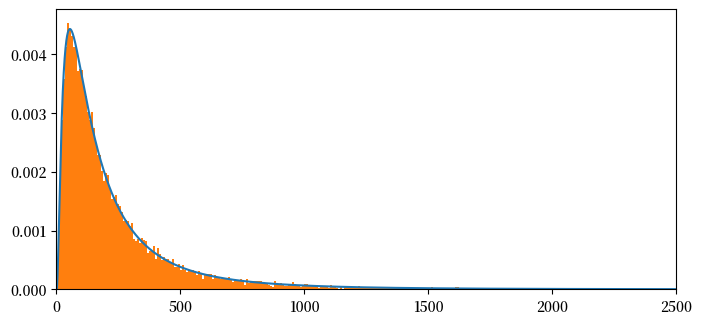

In [11]:
## 检查单元格 -- 注意当不进行归一化时会发生什么！
## 无需调整即可匹配。与上面进行比较

p1,p1_norm,x = pdf_seq(mu1,sigma1,I,m)
## 计算评估概率质量函数的点数
NT = x.size

plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(x[:int(NT)],p1[:int(NT)],label = '')
plt.xlim(0,2500)
count, bins, ignored = plt.hist(s1, 1000, density=True, align='mid')

plt.show()

In [12]:
# 从离散化的概率密度函数计算均值并与理论值进行比较

mean= np.sum(np.multiply(x[:NT],p1_norm[:NT]))
meantheory = np.exp(mu1+.5*sigma1**2)
mean, meantheory

(244.69059898302908, 244.69193226422038)

## 概率质量函数的卷积

现在让我们使用卷积定理来计算上面参数化的两个对数正态随机变量之和的概率分布。

我们还将计算上面构造的三个对数正态分布之和的概率。

在进行这些计算之前，我们需要解释我们选择的用于计算两个序列卷积的Python算法。

由于要进行卷积的序列很长，我们使用`scipy.signal.fftconvolve`函数而不是numpy.convolve函数。

这两个函数给出的结果实际上是等价的，但对于长序列来说，`scipy.signal.fftconvolve`要快得多。

程序`scipy.signal.fftconvolve`使用快速傅里叶变换及其逆变换来计算卷积。

让我们定义傅里叶变换和逆傅里叶变换。

序列$\{x_t\}_{t=0}^{T-1}$的**傅里叶变换**是一个复数序列$\{x(\omega_j)\}_{j=0}^{T-1}$，由下式给出：

$$
 x(\omega_j) = \sum_{t=0}^{T-1} x_t \exp(- i \omega_j t)
$$ (eq:ft1)

其中 $\omega_j = \frac{2 \pi j}{T}$，$j=0, 1, \ldots, T-1$。

序列 $\{x(\omega_j)\}_{j=0}^{T-1}$ 的**逆傅里叶变换**为

$$
 x_t = T^{-1} \sum_{j=0}^{T-1} x(\omega_j) \exp (i \omega_j t)
$$ (eq:ift1)

序列 $\{x_t\}_{t=0}^{T-1}$ 和 $\{x(\omega_j)\}_{j=0}^{T-1}$ 包含相同的信息。

方程对 {eq}`eq:ft1` 和 {eq}`eq:ift1` 说明了如何从一个序列恢复其傅里叶对应序列。

程序 `scipy.signal.fftconvolve` 利用了两个序列 $\{f_k\}$、$\{g_k\}$ 的卷积可以通过以下方式计算的定理：

- 计算序列 $\{f_k\}$ 和 $\{g_k\}$ 的傅里叶变换 $F(\omega)$、$G(\omega)$
- 形成乘积 $H (\omega) = F(\omega) G (\omega)$
- 卷积 $f * g$ 是 $H(\omega)$ 的逆傅里叶变换

**快速傅里叶变换**和相关的**逆快速傅里叶变换**能够非常快速地执行这些计算。

这就是 `scipy.signal.fftconvolve` 使用的算法。

让我们做一个预热计算，比较 `numpy.convolve` 和 `scipy.signal.fftconvolve` 所需的时间。

In [13]:

p1,p1_norm,x = pdf_seq(mu1,sigma1,I,m)
p2,p2_norm,x = pdf_seq(mu2,sigma2,I,m)
p3,p3_norm,x = pdf_seq(mu3,sigma3,I,m)

tic = time.perf_counter()

c1 = np.convolve(p1_norm,p2_norm)
c2 = np.convolve(c1,p3_norm)


toc = time.perf_counter()

tdiff1 = toc - tic

tic = time.perf_counter()

c1f = fftconvolve(p1_norm,p2_norm)
c2f = fftconvolve(c1f,p3_norm)
toc = time.perf_counter()

toc = time.perf_counter()

tdiff2 = toc - tic

print("time with np.convolve = ", tdiff1,  "; time with fftconvolve = ",  tdiff2)



time with np.convolve =  37.12749747999999 ; time with fftconvolve =  0.07504507099997682


快速傅里叶变换比 `numpy.convolve` 快两个数量级

现在让我们将计算得到的两个对数正态随机变量之和的概率质量函数近似值与我们上面形成的样本直方图进行对比绘制。

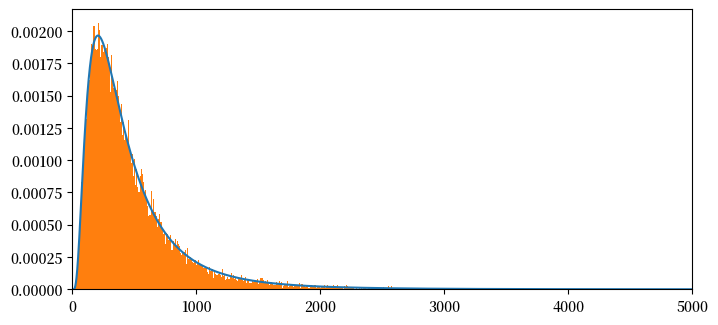

In [14]:
NT= np.size(x)

plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(x[:int(NT)],c1f[:int(NT)]/m,label = '')
plt.xlim(0,5000)

count, bins, ignored = plt.hist(ssum2, 1000, density=True, align='mid')
# plt.plot(P2P3[:10000],label = 'FFT method',linestyle = '--')

plt.show()

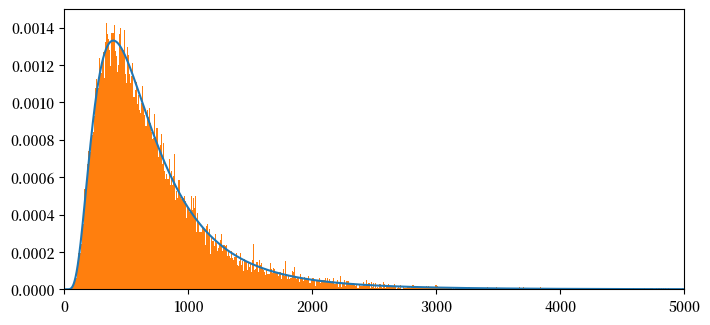

In [15]:
NT= np.size(x)
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(x[:int(NT)],c2f[:int(NT)]/m,label = '')
plt.xlim(0,5000)

count, bins, ignored = plt.hist(ssum3, 1000, density=True, align='mid')
# plt.plot(P2P3[:10000],label = 'FFT方法',linestyle = '--')

plt.show()

In [16]:
## 让我们计算离散化pdf的均值
mean= np.sum(np.multiply(x[:NT],c1f[:NT]))
# meantheory = np.exp(mu1+.5*sigma1**2)
mean, 2*meantheory

(489.3810974093853, 489.38386452844077)

In [17]:
## 让我们计算离散化pdf的均值
mean= np.sum(np.multiply(x[:NT],c2f[:NT]))
# meantheory = np.exp(mu1+.5*sigma1**2)
mean, 3*meantheory

(734.0714863312272, 734.0757967926611)

<!-- #region -->
## 故障树分析

我们即将应用卷积定理来计算故障树分析中**顶事件**的概率。

在应用卷积定理之前，我们首先描述将组成事件与我们要量化其故障率的**顶端**事件连接起来的模型。

该模型是El-Shanawany、Ardron和Walker {cite}`Ardron_2018`所描述的广泛使用的**故障树分析**的一个例子。

为了构建统计模型，我们反复使用所谓的**稀有事件近似**。

我们想要计算事件$A \cup B$的概率。

* 并集$A \cup B$是事件$A$或$B$发生的情况

概率法则告诉我们，$A$或$B$发生的概率为

$$ P(A \cup B) = P(A) + P(B) - P(A \cap B) $$

其中交集$A \cap B$是事件$A$**和**$B$都发生的情况，而并集$A \cup B$是事件$A$**或**$B$发生的情况。

如果$A$和$B$是独立的，那么

$$ P(A \cap B) = P(A) P(B)  $$

如果 $P(A)$ 和 $P(B)$ 都很小，那么 $P(A) P(B)$ 就更小。

**稀有事件近似**为

$$ P(A \cup B) \approx P(A) + P(B)  $$

这种近似方法在评估系统故障时被广泛使用。


## 应用

一个系统的设计特点是，当**任何**一个关键组件发生故障时，系统就会发生故障。

每个事件 $A_i$ 的故障概率 $P(A_i)$ 都很小。

我们假设组件的故障是统计独立的随机变量。


我们反复应用**稀有事件近似**，得到系统故障问题的以下公式：

$$ P(F) \approx P(A_1) + P (A_2) + \cdots + P (A_n) $$

或

$$
P(F) \approx \sum_{i=1}^n P (A_i)
$$ (eq:probtop)

每个事件的概率以每年故障率的形式记录。


## 未知的故障率

现在我们来讨论真正感兴趣的问题，参考 {cite}`Ardron_2018` 和 Greenfield and Sargent

{cite}`Greenfield_Sargent_1993` 遵循 Apostolakis {cite}`apostolakis1990` 的思路。

构成概率或失效率 $P(A_i)$ 并非先验已知，需要进行估计。

我们通过指定**概率的概率**来解决这个问题，这反映了对故障树分析输入中的构成概率的不确定性这一概念。

因此，我们假设系统分析师对系统组件的失效率 $P(A_i), i =1, \ldots, n$ 存在不确定性。

分析师通过将系统失效概率 $P(F)$ 和每个组件概率 $P(A_i)$ 视为随机变量来应对这种情况。

  * $P(A_i)$ 概率分布的离散程度表征了分析师对失效概率 $P(A_i)$ 的不确定性

  * $P(F)$ 的隐含概率分布的离散程度表征了分析师对系统失效概率的不确定性

这导致了有时被称为**层次化**模型，其中分析师对概率$P(A_i)$本身也有概率估计。

分析师通过以下假设来形式化他的不确定性：

* 失效概率$P(A_i)$本身是一个对数正态随机变量，其参数为$(\mu_i, \sigma_i)$。
* 对于所有$i \neq j$的配对，失效率$P(A_i)$和$P(A_j)$在统计上是相互独立的。

分析师通过阅读工程论文中的可靠性研究来校准失效事件$i = 1, \ldots, n$的参数$(\mu_i, \sigma_i)$，这些研究考察了与系统中使用的组件尽可能相似的组件的历史失效率。

分析师假设，这些关于年度失效率或失效时间的观测分散性的信息，可以帮助他预测零件在其系统中的性能表现。

分析师假设随机变量 $P(A_i)$ 在统计上是相互独立的。

分析师想要近似系统失效概率 $P(F)$ 的概率质量函数和累积分布函数。

  * 我们说概率质量函数是因为我们之前描述的对每个随机变量的离散化方式。

分析师通过重复应用卷积定理来计算**顶事件** $F$（即**系统失效**）的概率质量函数，以计算独立对数正态随机变量之和的概率分布，如方程 {eq}`eq:probtop` 所述。

## 废物提升机失效率

我们以接近实际的例子来说明，假设 $n = 14$。

该例子估计了核废料设施中一个关键提升机的年度失效率。

监管机构希望系统的设计能够使顶事件的失效率以高概率保持在较小值。

这个例子是{cite}`Greenfield_Sargent_1993`第27页表10中描述的设计方案B-2（案例I）。

该表描述了十四个对数正态随机变量的参数$\mu_i, \sigma_i$，这些随机变量由**七对**独立同分布的随机变量组成。

* 在每一对内，参数$\mu_i, \sigma_i$是相同的

* 如{cite}`Greenfield_Sargent_1993`第27页表10所述，七个唯一概率$P(A_i)$的对数正态分布参数已被校准为以下Python代码中的值：

In [18]:
mu1, sigma1 = 4.28, 1.1947
mu2, sigma2 = 3.39, 1.1947
mu3, sigma3 = 2.795, 1.1947
mu4, sigma4 = 2.717, 1.1947
mu5, sigma5 = 2.717, 1.1947
mu6, sigma6 = 1.444, 1.4632
mu7, sigma7 = -.040, 1.4632


```{note}
由于故障率都很小，具有上述参数值的对数正态分布实际上描述的是 $P(A_i)$ 乘以 $10^{-09}$。
```

所以我们将在概率质量函数和相关累积分布函数的 $x$ 轴上标注的概率应该乘以 $10^{-09}$

为了提取汇总计算分位数的表格，我们将使用一个辅助函数

In [19]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

我们在以下代码中计算所需的十三个卷积。

(请随意尝试不同的幂参数 $p$ 值，我们用它来设置网格中的点数，以构建离散化连续对数正态分布的概率质量函数。)

我们将绘制一个与{cite}`Greenfield_Sargent_1993`第29页图5中的累积分布函数(CDF)相对应的图，并且还将展示一个与他们第28页表11相对应的表。

In [20]:
p=15
I = 2**p # 截断值
m =  .05 # 增量大小




p1,p1_norm,x = pdf_seq(mu1,sigma1,I,m)
p2,p2_norm,x = pdf_seq(mu2,sigma2,I,m)
p3,p3_norm,x = pdf_seq(mu3,sigma3,I,m)
p4,p4_norm,x = pdf_seq(mu4,sigma4,I,m)
p5,p5_norm,x = pdf_seq(mu5,sigma5,I,m)
p6,p6_norm,x = pdf_seq(mu6,sigma6,I,m)
p7,p7_norm,x = pdf_seq(mu7,sigma7,I,m)
p8,p8_norm,x = pdf_seq(mu7,sigma7,I,m)
p9,p9_norm,x = pdf_seq(mu7,sigma7,I,m)
p10,p10_norm,x = pdf_seq(mu7,sigma7,I,m)
p11,p11_norm,x = pdf_seq(mu7,sigma7,I,m)
p12,p12_norm,x = pdf_seq(mu7,sigma7,I,m)
p13,p13_norm,x = pdf_seq(mu7,sigma7,I,m)
p14,p14_norm,x = pdf_seq(mu7,sigma7,I,m)

tic = time.perf_counter()

c1 = fftconvolve(p1_norm,p2_norm)
c2 = fftconvolve(c1,p3_norm)
c3 = fftconvolve(c2,p4_norm)
c4 = fftconvolve(c3,p5_norm)
c5 = fftconvolve(c4,p6_norm)
c6 = fftconvolve(c5,p7_norm)
c7 = fftconvolve(c6,p8_norm)
c8 = fftconvolve(c7,p9_norm)
c9 = fftconvolve(c8,p10_norm)
c10 = fftconvolve(c9,p11_norm)
c11 = fftconvolve(c10,p12_norm)
c12 = fftconvolve(c11,p13_norm)
c13 = fftconvolve(c12,p14_norm)

toc = time.perf_counter()

tdiff13 = toc - tic

print("13个卷积的计算时间 = ", tdiff13)


13个卷积的计算时间 =  3.1593598590000056


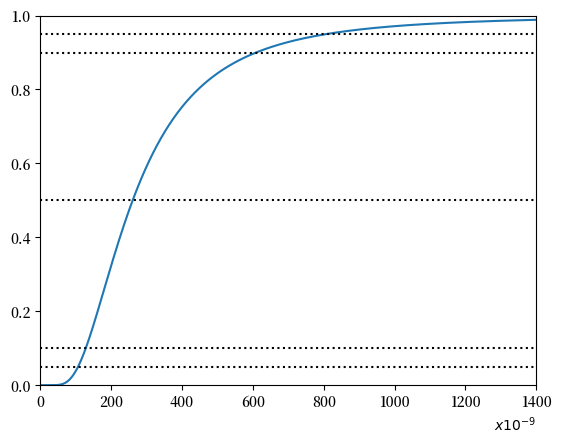

百分位数      x * 1e-9
----------  ----------
1%               76.15
5%              106.5
10%             128.2
50%             260.55
66.5%           338.55
85%             509.4
90%             608.8
95%             807.6
99%            1470.2
99.78%         2474.85


In [21]:
d13 = np.cumsum(c13)
Nx=int(1400)
plt.figure()
plt.plot(x[0:int(Nx/m)],d13[0:int(Nx/m)])  # 展示给Yad看 -- 我乘以了m -- 步长
plt.hlines(0.5,min(x),Nx,linestyles='dotted',colors = {'black'})
plt.hlines(0.9,min(x),Nx,linestyles='dotted',colors = {'black'})
plt.hlines(0.95,min(x),Nx,linestyles='dotted',colors = {'black'})
plt.hlines(0.1,min(x),Nx,linestyles='dotted',colors = {'black'})
plt.hlines(0.05,min(x),Nx,linestyles='dotted',colors = {'black'})
plt.ylim(0,1)
plt.xlim(0,Nx)
plt.xlabel("$x10^{-9}$",loc = "right")
plt.show()

x_1 = x[find_nearest(d13,0.01)]
x_5 = x[find_nearest(d13,0.05)]
x_10 = x[find_nearest(d13,0.1)]
x_50 = x[find_nearest(d13,0.50)]
x_66 = x[find_nearest(d13,0.665)]
x_85 = x[find_nearest(d13,0.85)]
x_90 = x[find_nearest(d13,0.90)]
x_95 = x[find_nearest(d13,0.95)]
x_99 = x[find_nearest(d13,0.99)]
x_9978 = x[find_nearest(d13,0.9978)]

print(tabulate([
    ['1%',f"{x_1}"],
    ['5%',f"{x_5}"],
    ['10%',f"{x_10}"],
    ['50%',f"{x_50}"],
    ['66.5%',f"{x_66}"],
    ['85%',f"{x_85}"],
    ['90%',f"{x_90}"],
    ['95%',f"{x_95}"],
    ['99%',f"{x_99}"],
    ['99.78%',f"{x_9978}"]],
    headers = ['百分位数', 'x * 1e-9']))

上表与 {cite}`Greenfield_Sargent_1993` 第28页表11的第2列数据非常接近。

差异可能是由于在输入 $\mu_i, \sigma_i, i = 1, \ldots, 14$ 时保留的小数位数略有不同，以及在离散化时使用的点数不同所致。